In [1]:
import torch
import os
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
from b3d.hgps_utils import load_video_to_numpy
from b3d import get_shared

# Single window

In [3]:
path = Path("data")/"pixel4a"
files = os.listdir(path)
print(f"Listing files from diretory...")
for i, f in enumerate(files):
    print(f"{i}:", f)

Listing files from diretory...
0: testvid6_cotracker.npz
1: testvid666.mp4
2: testvid6.mp4
3: testvid.mp4
4: testvid7_cotracker.npz
5: testvid3.mp4
6: testvid4_cotracker.npz
7: testvid5.mp4
8: testvid7.mp4
9: testvid4.mp4
10: testvid2.mp4
11: testvid5_cotracker.npz


In [5]:
fname = path/files[3]
vid = load_video_to_numpy(fname)
print(vid.shape)

(203, 1920, 1080, 3)


In [31]:
import jax
import jax.numpy as jnp


    Reducing frame rate or the video `vid` by a factor of 5 to 6 FPS.

    vid.shape    : (203, 1920, 1080, 3)
    frames.shape : (25, 1920, 1080, 3)
    New FPS      : 6

[ 0  2  5  8 10 13 16 18 21 24]


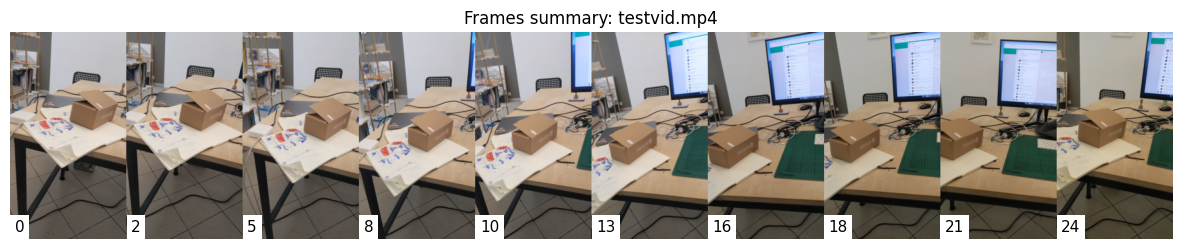

In [67]:
# Total length of the frames tensor, and 
# the step size to collect frames from the video
T0 = 15
T1 = 40
step = 5

# NOTE: For some reason color channels are ordered weird.
# NOTE: Pixel4a FPS is ~30
frames = np.array(vid[::step,:,:,::-1])[T0:T1]
fps    = 30/step

print(f"""
    Reducing frame rate or the video `vid` by a factor of {step} to {int(fps)} FPS.
    Collecting the frames {T0}...{T1} at that new rate ({int(fps)} FPS) into the array `frames`:

    vid.shape    : {vid.shape}
    frames.shape : {frames.shape}
    New FPS      : {int(fps)}
""")

frames_ = jax.vmap(jax.image.resize, (0,None,None))(frames/255, (frames.shape[1]//6, frames.shape[2]//6, 3), "linear")
frames_ = (frames_*255).astype(jnp.int32)


ts = np.linspace(0., frames.shape[0]-1, 10).astype(np.int32)
print(ts)
# ==================
fig, ax = plt.subplots(1,1, figsize=(15,4))
ax.set_title(f"Frames summary: {fname.name}")
ax.imshow(np.concatenate(frames_[ts], axis=1))

for i,t in enumerate(ts):
    ax.text(i*frames_.shape[2] + 7, frames_.shape[1] - 7, f"{t}", size=11, rotation=0.,
            ha="left", va="bottom",
            bbox=dict(boxstyle="square",
                    ec=(1., 1., 1., 0.),
                    fc=(1., 1., 1., 1.),
                    )
            )

ax.axis("off");

In [2]:
device = 'cuda'
# Not sure if that is needed anymore
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

# Load dataa
# path  = get_shared()/"datasets"/"slam2d3d"/"pixel4a"/"dynamic_sfm"
path = Path("data")
fname = path/"demo_1.mp4"
vid = load_video_to_numpy(fname)

print(vid.shape)

Error: Could not open video file.


AttributeError: 'NoneType' object has no attribute 'shape'


    Reducing frame rate or the video `vid` by a factor of 5.

    vid.shape    : (241, 1920, 1080, 3)
    frames.shape : (20, 1920, 1080, 3)
    New FPS      :  6.0

[ 0  2  4  6  8 10 12 14 16 19]


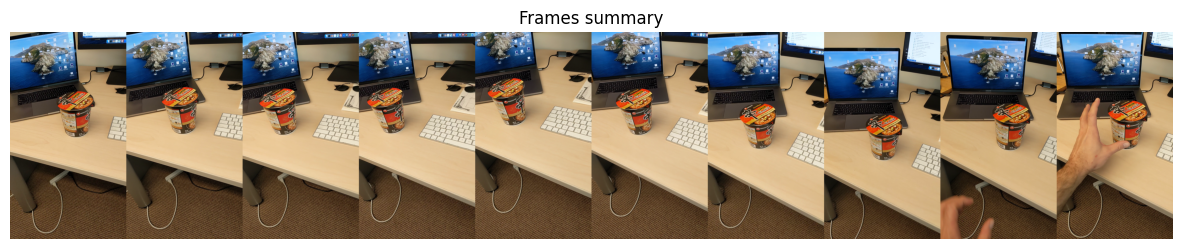

In [14]:
# Get rid of the video and free up some space
del vid;

In [15]:
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker2").to(device)
print("Cotracker on device")

Using cache found in /home/mirko/.cache/torch/hub/facebookresearch_co-tracker_main


Cotracker on device


In [16]:
video = torch.tensor(frames).permute(0, 3, 1, 2)[None].float().to(device)  # B T C H W
print("Video on device")

Video on device


In [17]:
grid_size = 20
t0 = time.time()
pred_tracks, pred_visibility = cotracker(video[:,:T], grid_size=grid_size) # B T N 2,  B T N 1
t1 = time.time()

print("Cotracker took ", t1-t0, " seconds")

pred_tracks_ = pred_tracks.cpu().numpy()
pred_visibility_ = pred_visibility.cpu().numpy()


np.savez(f"{fname.parent/fname.stem}_cotracker.npz", 
         times= ts,
         fps = fps,
         pred_tracks = pred_tracks_, 
         pred_visibility = pred_visibility_, 
         rgb = frames)


print(f"""
    Saved data {fname.parent/fname.stem}_cotracker.npz
""")

Cotracker took  1.0203392505645752  seconds

    Saved data /home/mirko/workspace/b3d/assets/shared_data_bucket/datasets/slam2d3d/pixel4a/dynamic_sfm/demo_1_cotracker.npz



# Overlapping windows

In [2]:
device = 'cuda'
# Not sure if that is needed anymore
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

# Load data
path  = get_shared()/"datasets"/"slam2d3d"/"pixel4a"/"dynamic_sfm"
fname = path/"demo_june_2.mp4"
vid = load_video_to_numpy(fname)

print(vid.shape)

(358, 1920, 1080, 3)


In [3]:
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker2").to(device)
print("Cotracker on device")

Using cache found in /home/mirko/.cache/torch/hub/facebookresearch_co-tracker_main


Cotracker on device


In [4]:
# Subsampling original video
# NOTE: For some reason color channels in original are reverse ordered.
step = 5
vid_ = vid[::step,:,:,::-1]
del vid;

# Sliding windows
window_length  = 20
window_overlap = window_length//2

num_windows = vid_.shape[0]//(window_length-window_overlap)

print(f"""
    Num windows: {num_windows}
    New FPS: {30/step: 0.1f}
""")


    Num windows: 7
    New FPS:  6.0



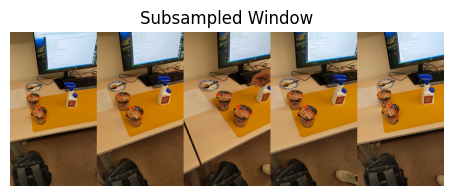

In [5]:
def get_window(vid, i, L, O):
    T = vid.shape[0]
    t0 = np.arange(T, step=(L-O))[i]
    t1 = min(t0+L,T)
    ts = np.arange(t0,t1)
    frames = np.array(vid[ts])
    return frames, ts


frames, ts = get_window(vid_, 1, window_length, window_overlap)
# ==================
fig, ax = plt.subplots(1,1, figsize=(10,2))

ts = np.linspace(0,window_length-1, 5).astype(int)

ax.set_title(f"Subsampled Window")
ax.imshow(np.concatenate(frames[ts], axis=1))
ax.axis("off");
del frames;

In [6]:
for i in np.arange(num_windows)[:5]:
    frames, ts =  get_window(vid_, i, window_length, window_overlap)
    print(f"Processing Window {i+1} (of {num_windows}): {ts[0]}...{ts[-1]}")

    video = torch.tensor(frames).permute(0, 3, 1, 2)[None].float().to(device)  # B T C H W
    grid_size = 50
    pred_tracks, pred_visibility = cotracker(video[:,:], grid_size=grid_size) # B T N 2,  B T N 1
    pred_tracks_ = pred_tracks.cpu().numpy()
    pred_visibility_ = pred_visibility.cpu().numpy()

    fname_ = Path(f"{fname.parent/fname.stem}_cotracker_window_{i}.npz")
    np.savez(fname_, 
            times = ts,
            pred_tracks = pred_tracks_, 
            pred_visibility = pred_visibility_, 
            rgb = frames)

    print(f"...saved to: {fname_.stem}")

Processing Window 1 (of 7): 0...19
...saved to: demo_june_2_cotracker_window_0
Processing Window 2 (of 7): 10...29
...saved to: demo_june_2_cotracker_window_1
Processing Window 3 (of 7): 20...39
...saved to: demo_june_2_cotracker_window_2
Processing Window 4 (of 7): 30...49
...saved to: demo_june_2_cotracker_window_3
Processing Window 5 (of 7): 40...59
...saved to: demo_june_2_cotracker_window_4


# Appendix

In [ ]:
# grid_size = 50

# video1 = torch.tensor(frames[:T//2+1:-1].copy()).permute(0, 3, 1, 2)[None].float().to(device)  # B T C H W
# video2 = torch.tensor(frames[T//2:T].copy()).permute(0, 3, 1, 2)[None].float().to(device)  # B T C H W

# tracks1, vis1 = cotracker(video1, grid_size=grid_size) # B T N 2,  B T N 1
# tracks2, vis2 = cotracker(video2, grid_size=grid_size) # B T N 2,  B T N 1

# track_ = np.concatenate([tracks1.cpu().numpy()[0,::-1], tracks2.cpu().numpy()[0]], axis=0)
# vis_   = np.concatenate([vis1.cpu().numpy()[0,::-1], vis2.cpu().numpy()[0]], axis=0)

# np.savez(f"{fname.parent/fname.stem}_cotracker.npz", pred_tracks=track_, pred_visibility=vis_, rgb=frames[:T])
# print(f"{fname.parent/fname.stem}_cotracker.npz")